<a href="https://colab.research.google.com/github/laytio/task-laith/blob/MAIN/task_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **load and Preprocess the Dataset**

 **Upload files from local system to Colab environment**


In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"laithyahia","key":"d405090e03d356b0ebcda7ad882bfac1"}'}

**Downloading and Extracting Kaggle Dataset**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d hugopaigneau/playing-cards-dataset
!unzip playing-cards-dataset.zip -d playing_cards_dataset


Streaming output truncated to the last 5000 lines.
  inflating: playing_cards_dataset/train_zipped/492794209.jpg  
  inflating: playing_cards_dataset/train_zipped/492794209.xml  
  inflating: playing_cards_dataset/train_zipped/492796977.jpg  
  inflating: playing_cards_dataset/train_zipped/492796977.xml  
  inflating: playing_cards_dataset/train_zipped/494204224.jpg  
  inflating: playing_cards_dataset/train_zipped/494204224.xml  
  inflating: playing_cards_dataset/train_zipped/494354857.jpg  
  inflating: playing_cards_dataset/train_zipped/494354857.xml  
  inflating: playing_cards_dataset/train_zipped/494502285.jpg  
  inflating: playing_cards_dataset/train_zipped/494502285.xml  
  inflating: playing_cards_dataset/train_zipped/494518923.jpg  
  inflating: playing_cards_dataset/train_zipped/494518923.xml  
  inflating: playing_cards_dataset/train_zipped/494542149.jpg  
  inflating: playing_cards_dataset/train_zipped/494542149.xml  
  inflating: playing_cards_dataset/train_zipped/49480

**Convert XML Annotations to COCO and YOLO Formats**

In [3]:
import json
import xml.etree.ElementTree as ET
from glob import glob
import os
import shutil

  # Convert XML to COCO format
def convert_to_coco(xml_files, output_json_path, images_dir):
    # Ensure the output directory exists
    os.makedirs(os.path.dirname(output_json_path), exist_ok=True)

    coco_format = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    category_set = {}
    annotation_id = 1
    image_id = 1

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # General information about the image
        filename = root.find('filename').text
        image_path = os.path.join(images_dir, filename)
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)

        image_info = {
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height
        }
        coco_format["images"].append(image_info)

        # Bounding boxes
        for obj in root.findall('object'):
            class_name = obj.find('name').text
            if class_name not in category_set:
                category_set[class_name] = len(category_set) + 1
                category_info = {
                    "id": category_set[class_name],
                    "name": class_name
                }
                coco_format["categories"].append(category_info)

            category_id = category_set[class_name]
            bndbox = obj.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            width = xmax - xmin
            height = ymax - ymin

            annotation_info = {
                "id": annotation_id,
                "image_id": image_id,
                "category_id": category_id,
                "bbox": [xmin, ymin, width, height],
                "area": width * height,
                "iscrowd": 0
            }
            coco_format["annotations"].append(annotation_info)
            annotation_id += 1

        image_id += 1

    with open(output_json_path, 'w') as json_file:
        json.dump(coco_format, json_file)

# Paths to XML files and output JSON files
train_xml_files = glob('/content/playing_cards_dataset/train_zipped/*.xml')
test_xml_files = glob('/content/playing_cards_dataset/test_zipped/*.xml')
train_images_dir = '/content/playing_cards_dataset/train_zipped'
test_images_dir = '/content/playing_cards_dataset/test_zipped'
train_output_json_path = '/content/playing_cards_dataset/train_annotations.json'
test_output_json_path = '/content/playing_cards_dataset/test_annotations.json'

convert_to_coco(train_xml_files, train_output_json_path, train_images_dir)
convert_to_coco(test_xml_files, test_output_json_path, test_images_dir)

# Create YOLO files from COCO annotations
def create_yolo_files(json_path, images_dir, output_dir):
    with open(json_path) as json_file:
        data = json.load(json_file)

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for image_info in data['images']:
        image_id = image_info['id']
        image_filename = image_info['file_name']
        shutil.copy(os.path.join(images_dir, image_filename), os.path.join(output_dir, image_filename))

        annotations = [ann for ann in data['annotations'] if ann['image_id'] == image_id]
        yolo_annotation = []

        for ann in annotations:
            category_id = ann['category_id'] - 1  # YOLO labels start at 0
            bbox = ann['bbox']
            x_center = (bbox[0] + bbox[2] / 2) / image_info['width']
            y_center = (bbox[1] + bbox[3] / 2) / image_info['height']
            bbox_width = bbox[2] / image_info['width']
            bbox_height = bbox[3] / image_info['height']

            yolo_annotation.append(f"{category_id} {x_center} {y_center} {bbox_width} {bbox_height}")

        annotation_filename = os.path.splitext(image_filename)[0] + '.txt'
        annotation_path = os.path.join(output_dir, annotation_filename)

        with open(annotation_path, 'w') as f:
            f.write('\n'.join(yolo_annotation))

# Convert train and test data to YOLO format
create_yolo_files(train_output_json_path, train_images_dir, '/content/playing_cards_dataset/train_yolo')
create_yolo_files(test_output_json_path, test_images_dir, '/content/playing_cards_dataset/test_yolo')


**Apply Augmentations to Images Using Albumentations**

In [4]:
!pip install albumentations

import albumentations as A
import cv2
import numpy as np
from glob import glob
import os

# Define the augmentation pipeline
transform = A.Compose([
    A.RandomCrop(width=640, height=640, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.GaussNoise(p=0.2)
])

def augment_image(image_path, output_dir):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


    augmented = transform(image=img)
    augmented_img = augmented['image']

    # Save the augmented image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, cv2.cvtColor(augmented_img, cv2.COLOR_RGB2BGR))

# Apply augmentation to all images in the dataset
image_files = glob('/content/playing_cards_dataset/train_yolo/*.jpg')
output_dir = '/content/playing_cards_dataset/train_yolo_augmented'
os.makedirs(output_dir, exist_ok=True)


for image_file in image_files:
    augment_image(image_file, output_dir)


# **Train the Model**

In [5]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

**Generate `data.yaml` Configuration File for YOLO**

In [6]:
  # Create a data.yaml file
categories = []
with open(train_output_json_path) as json_file:
    data = json.load(json_file)
    categories = [category['name'] for category in data['categories']]

data_yaml = f"""
train: /content/playing_cards_dataset/train_yolo
val: /content/playing_cards_dataset/test_yolo

nc: {len(categories)}  # Number of classes
names: {categories}
"""

with open('/content/playing_cards_dataset/data.yaml', 'w') as f:
    f.write(data_yaml)


**Train YOLO Model with Custom Dataset**

In [1]:
from ultralytics import YOLO
import torch
model = YOLO("yolov10x.pt")  # Load a pretrained model


torch.cuda.empty_cache()

model.train(
    data="/content/playing_cards_dataset/data.yaml",
    epochs=10,
    imgsz=448,
)


Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov10x.pt, data=/content/playing_cards_dataset/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=448, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_

train: Scanning /content/playing_cards_dataset/train_yolo.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/playing_cards_dataset/test_yolo.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 185 weight(decay=0.0), 198 weight(decay=0.0005), 197 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 448 train, 448 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      10.2G      1.884      5.115       1.77         63        448: 100%|██████████| 313/313 [03:51<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:21<00:00,  1.48it/s]


                   all       1000       8004     0.0131      0.191     0.0324     0.0272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      9.88G      1.026      1.125      1.571         62        448: 100%|██████████| 313/313 [03:39<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.63it/s]


                   all       1000       8004     0.0152      0.108      0.032     0.0269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10        10G     0.9231     0.7538      1.561         60        448: 100%|██████████| 313/313 [03:37<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


                   all       1000       8004       0.02     0.0895     0.0341     0.0301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      9.99G     0.8528     0.6029      1.553         59        448: 100%|██████████| 313/313 [03:36<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]

                   all       1000       8004      0.019     0.0191     0.0213     0.0184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10        10G     0.8056     0.5151      1.552         67        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]


                   all       1000       8004     0.0181     0.0185     0.0266     0.0243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      9.88G     0.7579     0.4513       1.55         57        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.68it/s]


                   all       1000       8004      0.018     0.0179     0.0215     0.0193

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10        10G      0.725     0.4146      1.547         64        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

                   all       1000       8004     0.0188     0.0189     0.0222     0.0205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10        10G     0.6895     0.3787      1.541         61        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.66it/s]


                   all       1000       8004     0.0181     0.0189     0.0201     0.0183

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10        10G     0.6592     0.3453      1.544         62        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.65it/s]

                   all       1000       8004     0.0185     0.0181     0.0227     0.0212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      9.88G       0.63     0.3245       1.54         61        448: 100%|██████████| 313/313 [03:35<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:19<00:00,  1.67it/s]


                   all       1000       8004     0.0187     0.0189       0.02     0.0189

10 epochs completed in 0.678 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 64.3MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 64.3MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.2.67 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10x summary (fused): 503 layers, 31,684,232 parameters, 0 gradients, 170.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:25<00:00,  1.24it/s]


                   all       1000       8004     0.0199     0.0894     0.0341     0.0301
                   10d        129        161          0          0          0          0
                    Jc        132        165          0          0          0          0
                    Jh        126        146          0          0          0          0
                    6h        133        154          0          0          0          0
                   10c        121        149          0          0          0          0
                    Qh        115        138          0          0          0          0
                    3s        122        141     0.0326      0.106     0.0185      0.018
                    2h        115        136          0          0          0          0
                    Ac        137        159          0          0          0          0
                    6c        131        154          0          0          0          0
                    7

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0f756ab070>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.03303

#**Perform Object Detection on Uploaded Image Using YOLO**


Saving 051605206.jpg to 051605206.jpg

0: 448x448 1 2h, 1 7s, 2 3hs, 1 Qs, 1 2d, 1 Kd, 53.1ms
Speed: 2.7ms preprocess, 53.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 448)
Detections: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: '10d', 1: 'Jc', 2: 'Jh', 3: '6h', 4: '10c', 5: 'Qh', 6: '3s', 7: '2h', 8: 'Ac', 9: '6c', 10: '7h', 11: '9h', 12: '6s', 13: '7s', 14: '4h', 15: '10h', 16: 'Js', 17: 'Ad', 18: '10s', 19: '5s', 20: '6d', 21: '3h', 22: '7c', 23: '8d', 24: '3c', 25: 'Qs', 26: 'Kh', 27: '9c', 28: '4s', 29: 'As', 30: '5c', 31: '2d', 32: 'Kc', 33: '8c', 34: '4d', 35: 'Ah', 36: '7d', 37: '5d', 38: 'Qd', 39: '3d', 40: '8h', 41: '9d', 42: '4c', 43: '8s', 44: 'Qc', 45: '5h', 46: 'Jd', 47: '9s', 48: '2c', 49: '2s', 50: 'Ks', 51: 'Kd'}
obb: None
orig_img: array([[[ 26,  79, 152],
        [ 19,  72, 145],
        [ 20,  73, 146],
        ...,
        [ 25,  67, 166],
      

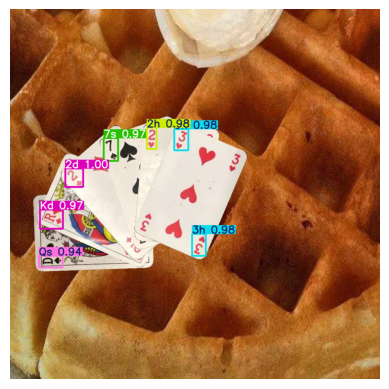

In [5]:
import torch
import numpy as np
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
from google.colab import files

def predict_card(image_path, model_path, output_path, plot_output=False):
    # Load the model
    model = YOLO(model_path)

    # Read the image
    image = cv2.imread(image_path)

    # Make predictions
    results = model(image)

    # Extract the annotated image
    annotated_image = results[0].plot()  # Access the first result and plot it

    # Save the output image if requested
    if plot_output:
        cv2.imwrite(output_path, annotated_image)

    return results, annotated_image

  # Upload an image
uploaded = files.upload()


for filename in uploaded.keys():
    # Assume model is already uploaded and located at '/content/runs/detect/train4/weights/best.pt'
    output_image_path = '/content/output_image.jpg'

    # Perform prediction
    detections, annotated_image = predict_card(filename, '/content/runs/detect/train4/weights/last.pt', output_path=output_image_path, plot_output=True)
    print(f"Detections: {detections}")

    # Display the image with detections
    if annotated_image is not None:
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [3]:
import shutil
from google.colab import files

shutil.make_archive('/content/runs/detect/train4', 'zip', '/content/runs/detect/train4')

files.download('/content/runs/detect/train4.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>